In [ ]:
import itertools
import numpy as np
import pandas as pd
import scipy.stats as sps
import seaborn as sns
from tqdm.notebook import tqdm

from scipy.linalg import sqrtm

from statsmodels.sandbox.stats.multicomp import multipletests

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1, palette="Set2")

Исследуем влияние методов коррекции при множественной проверке гипотез на различные показатели качества.

**Теоретическая справка**

Приведем определения всех составляющих:
* $V_{\mathsf{P} S}(X)$ &mdash; количество верных гипотез, которые были отвергнуты для $\mathsf{P}$ критерием $S$ по выборке $X$,
* $R_S(X)$ &mdash; количество отвергнутых гипотез критерием $S$ по выборке $X$,
* $U_{\mathsf{P} S}(X)$ &mdash; количество *не*верных гипотез, которые были отвергнуты для $\mathsf{P}$ критерием $S$ по выборке $X$,
* $T_{\mathsf{P}}$ &mdash; количество *не*верных гипотез для $\mathsf{P}$.

Тогда характеристики определяются следующим образом.
* Вероятность хотя бы одного неверного отвержения
$$FWER = \mathsf{P}(V_{\mathsf{P} S}(X) > 0).$$

* Ожидаемая доля ложных отклонений среди всех отвергнутых гипотез
$$FDR = \mathsf{E}_\mathsf{P} \frac{V_{\mathsf{P} S}\;(X)}{\max(R_S(X), 1)}.$$

* Ожидаемая доля правильный отклонений среди всех неверных гипотез
$$Power = \mathsf{E}_\mathsf{P} \frac{U_{\mathsf{P} S}\;(X)}{\max(T_{\mathsf{P}}, 1)}.$$

**Постановка задачи**

Дана выборка $X = (X_1, ..., X_n)$ из многомерного нормального распределения с неизвестным вектором средних ${\theta}$ и известной матрицей ковариаций ${\Sigma}$.
Для каждой из компонент вектора проверяется гипотеза $\mathsf{H}_j\colon\ \theta_j = 0$ против правосторонней альтернативы. Соответственно, используется правосторонний критерий на основе выборочного среднего, который является при этом равномерно наиболее мощным.


*Задача*: исследовать, как ведут себя характеристики процедур МПГ в зависимости от
1. количества верных гипотез,
2. используемой процедуры МПГ,
3. степени скоррелированности компонент.

*Пояснения по каждому пункту.*

1. Для упрощения задачи будем рассматривать простую альтернативную гипотезу $\mathsf{H}'_j\colon\ \theta_j = \theta_{1j}$, где $\theta_{1j} > 0$ &mdash; фиксированное положительное число. На самом деле конкретный выбор $\theta_{1j}$ влияет только на масштаб. Тем самым мы концентрируемся на верности/неверности гипотезы, а не на конкретных распределениях их альтернативы.


2. Исследуемые методы корректировки:
    * отсутствие корректировки,
    * метод Бонферрони,
    * метод Холма,
    * метод Бенджамини-Иекутиели.


3. Для исследования степени скоррелированности будем рассматривать такие матрицы ковариаций ${\Sigma}$, у которых на диагонали стоит 1, а вне диагонали &mdash; число $\gamma \in [0, 1]$, отвечающее за корреляцию выборок. Напомним, при $\gamma=0$ выборки независимы, а при $\gamma=1$ выборки идентичны. Соответственно, в процессе исследования изучим поведение характеристик для независимых, зависимых, идентичных выборок.



**Исследование**

Для проведения исследования нужно реализовать примерно следующую процедуру.
* перебираем исследуемые варианты распределения данных, то есть числа $\gamma$
    * перебираем все комбинации верных/неверных гипотез
        * совершаем достаточно много итераций метода Монте-Карло
            * генерируем выборку
            * добавляем смещение в тех случаях, где основная гипотеза не верна
            * применяем критерий
            * для рассматриваемых методов МПГ:
                * применяем корректировку
                * сохраняем числа V, R, U, T
        * оцениваем FWER, FDR, Power
        

Поскольку с помощью Монте-Карло мы оцениваем разные величины, *для ускорения процедуры и получения менее шумных графиков* можно использовать одинаковые семплы для разных процедур. Тем самым схема получается следующая
* совершаем достаточно много итераций метода Монте-Карло
    * генерируем выборку с независимыми компонентами
    * перебираем исследуемые варианты распределения данных, то есть числа $\gamma$
        * меняем матрицу ковариаций (нужно домножить на корень из матрицы)
        * перебираем все комбинации верных/неверных гипотез
            * добавляем смещение в тех случаях, где основная гипотеза не верна
            * применяем критерий
            * для рассматриваемых методов МПГ:
                * применяем корректировку
                * сохраняем числа V, R, U, T
* оцениваем FWER, FDR, Power во всех случаях

Возьмем следующие параметра эксперимента

In [ ]:
sample_size = 100  # размер выборки на каждой итерации
n_iters = int(1e4)  # число экспериментов для каждой конфигурации
alpha = 0.05  # уровень значимости

theta_1 = 0.25  # значение из альтернативной гипотезы
n_hypothesis = 3  # количество гипотез

# Список всех комбинаций верных и неверных гипотез
hypothesis_mask_list = np.array(list(itertools.product([0, 1], repeat=n_hypothesis)))
print(hypothesis_mask_list)

# Перебираемые значения корреляции
n_correlations = 11
correlations_list = np.linspace(0, 1, n_correlations)
print(correlations_list)

[[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


Для каждой характеристики построим графики, используя сетку, например $2 \times 4$. На каждом графике для определенной комбинации верности гипотез построим график это характеристики в зависимости от значения корреляции $\gamma$ для всех методов корректировки МПГ. Для FWER и FDR отметьте также уровень $\alpha=0.05$

Для удобства реализуем функции.

In [ ]:
def criteria(sample, axis=-1, theta_0=0, std=1):
    """Отвечает за вычисление p-value.

    :param sample: выборка
    :param axis: ось, отвечающая за размер выборки
    :param theta_0: параметр сдвига при справедливости H_0
    :param std: параметр масштаба
    :returns: значение p-value при правосторонней альтернативе
    """
    sample_size = shift_samples.shape[axis]
    mean = shift_samples.mean(axis=axis)
    return sps.norm.sf(mean, loc=theta_0, scale=std / np.sqrt(sample_size))


def holm_correction(pvalues, alpha=0.05):
    """Реализует метод Холма.


    :param pvalues: значения p-value для каждой гипотезы
    :param alpha: уровень значимости
    :returns: булев массив, отвечающий за отвержение каждой из гипотез
    """
    hyp_range = np.arange(len(pvalues))
    order = np.argsort(pvalues)
    is_reject = pvalues[order] <= alpha / (len(pvalues) - hyp_range)
    is_reject = np.cumprod(is_reject).astype(bool)
    source_order = np.argsort(hyp_range[order])
    return is_reject[source_order]


def by_correction(pvalues, alpha=0.05):
    """Реализует метод Бенджамини-Иекутиели.

    :param pvalues: значения p-value для каждой гипотезы
    :param alpha: уровень значимости
    :returns: булев массив, отвечающий за отвержение каждой из гипотез
    """
    hyp_range = np.arange(len(pvalues))
    order = np.argsort(pvalues)
    denominator = (1 / (hyp_range + 1)).sum() * len(pvalues)

    is_reject = pvalues[order] <= alpha * (hyp_range + 1) / denominator
    is_reject = (1 - np.cumprod(1 - is_reject[::-1])[::-1]).astype(bool)
    source_order = np.argsort(hyp_range[order])
    return is_reject[source_order]

In [ ]:
# названия методов
methods = ["no correction", "bonferroni", "holm", "by"]

# инициализация массивов чисел R, V, U нулями
R_list = np.zeros((n_iters, len(methods), n_correlations, len(hypothesis_mask_list)))
V_list = np.zeros((n_iters, len(methods), n_correlations, len(hypothesis_mask_list)))
U_list = np.zeros((n_iters, len(methods), n_correlations, len(hypothesis_mask_list)))

# делаем n_iters итераций метода Монте-Карло
for id_iter in tqdm(range(n_iters)):
    # семплируем выборку
    samples = np.random.normal(size=(n_hypothesis, sample_size))

    # перебираем числа gamma
    for corr_id, correlation in enumerate(correlations_list):
        # создаём матрицу ковариаций
        cov_matrix = (
            np.zeros((n_hypothesis, n_hypothesis))
            + correlation
            + (1 - correlation) * np.eye(n_hypothesis)
        )
        # извлекаем квадратный корень из матррицы
        sqrt_cov_matrix = sqrtm(cov_matrix)
        # скоррелированные выборки
        correlated_samples = sqrt_cov_matrix @ samples

        # перебираем варианты гипотез
        for hyp_id, hypothesis_mask in enumerate(hypothesis_mask_list):
            # в зависимости от справедливости гипотезы модифицируем выборки
            shift_samples = correlated_samples + hypothesis_mask[None, :].T * theta_1
            # вычисляем p-value
            pvalues = criteria(shift_samples)

            # перебираем методы
            for correction_id, correction_name in enumerate(methods):
                if correction_name == "no correction":
                    reject = pvalues <= alpha
                elif correction_name == "bonferroni":
                    reject = multipletests(pvalues, alpha=alpha, method="bonferroni")[0]
                elif correction_name == "holm":
                    reject = holm_correction(pvalues, alpha=alpha)
                elif correction_name == "by":
                    reject = by_correction(pvalues, alpha=alpha)

                # вычисляем значения
                R_list[id_iter, correction_id, corr_id, hyp_id] = reject.sum()
                V_list[id_iter, correction_id, corr_id, hyp_id] = reject[
                    ~hypothesis_mask.astype(bool)
                ].sum()
                U_list[id_iter, correction_id, corr_id, hyp_id] = reject[
                    hypothesis_mask.astype(bool)
                ].mean()

  0%|          | 0/10000 [00:00<?, ?it/s]

/var/folders/dx/k5v62n_50s7bgqb83lyp72j40000gq/T/ipykernel_71659/3680547651.py:50: RuntimeWarning: Mean of empty slice.
  U_list[id_iter, correction_id, corr_id, hyp_id] = reject[
/Users/d.s.polozov/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Теперь для каждого случая оценим FWER, FDR и Power.

In [ ]:
# оцениваем FWER
fwer = (V_list > 0).mean(axis=0)

# оцениваем FDR
R_list_max = np.array(R_list)
R_list_max[R_list_max == 0] = 1
fdr = (V_list / R_list_max).mean(axis=0)

# оцениваем Power
power = U_list.mean(axis=0)

А теперь посмотрим на графики. Реализуем функции отрисовки.

In [ ]:
def plot_mht_metrics(
    metric_name,
    metric_values,
    methods,
    methods_dict,
    hypothesis_mask_list,
    correlations_list,
):
    """Выполняет отрисовку графика, соответствующего одной из характеристик МПГ.

    :param metric_name: название характеристики
    :param metric_values: значения характеристики
    :param methods: названия методов
    :param methods_dict: словарь перевода названий методов
    :param hypothesis_mask_list: список масок справедливости гипотез
    :param correlations_list: список значений gamma
    """

    with sns.axes_style("darkgrid"):
        plt.figure(figsize=(15, 7))
        # рисуем для каждой маски справедливости гипотез
        for hyp_id, hypothesis_mask in enumerate(hypothesis_mask_list):
            plt.subplot(2, 4, hyp_id + 1)
            if metric_name in ["FWER", "FDR"]:
                plt.hlines(0.05, 0, 1, color="red", lw=7, alpha=0.2)
            for correction_id, correction_name in enumerate(methods):
                plt.plot(
                    correlations_list,
                    metric_values[correction_id, :, hyp_id],
                    lw=3,
                    label=methods_dict[correction_name],
                )
            plt.title(f"Маска справедливости гипотез:\n{hypothesis_mask}")
            plt.xlabel("$\\gamma$")
            if hyp_id % 4 == 0:
                plt.ylabel("Значение характеристики")
            if (metric_name == "Power" and hyp_id == 0) or (
                metric_name != "Power" and hyp_id == 7
            ):
                plt.legend(loc=5)

        plt.suptitle(f"Исследование поведения {metric_name}")
        plt.tight_layout()

Начинаем с FWER.

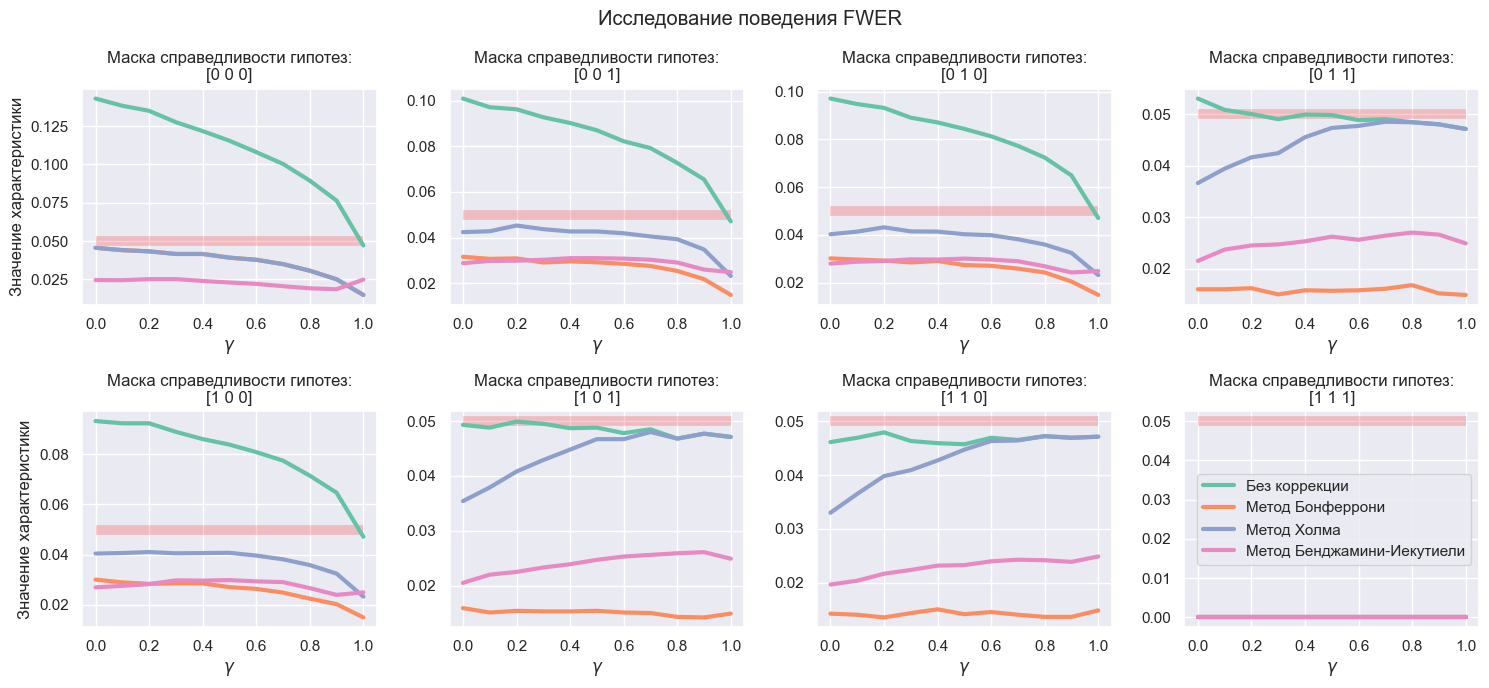

In [ ]:
# для удобства восприятия графика переводим названия на русский
methods_dict = {
    "no correction": "Без коррекции",
    "bonferroni": "Метод Бонферрони",
    "holm": "Метод Холма",
    "by": "Метод Бенджамини-Иекутиели",
}

plot_mht_metrics(
    "FWER", fwer, methods, methods_dict, hypothesis_mask_list, correlations_list
)

Продолжаем с FDR.

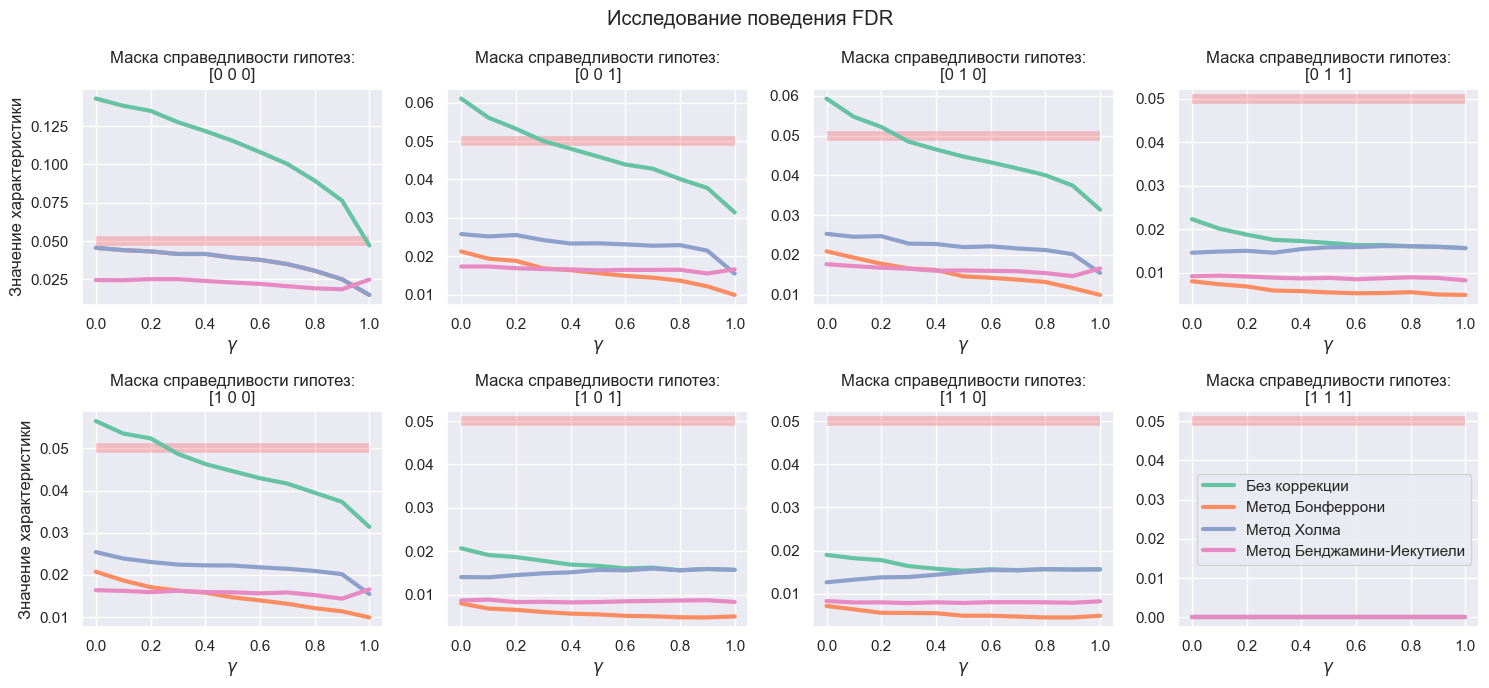

In [ ]:
plot_mht_metrics(
    "FDR", fdr, methods, methods_dict, hypothesis_mask_list, correlations_list
)

Заканчиваем с Power.

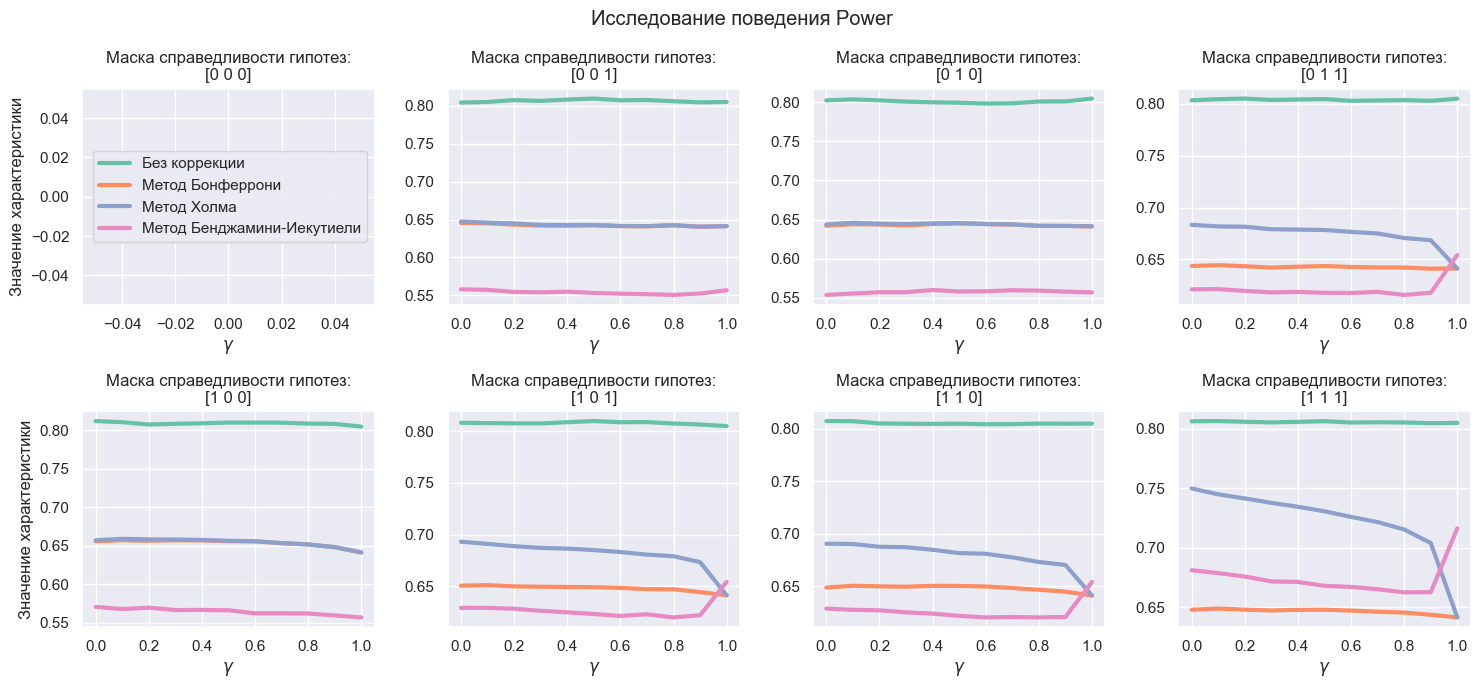

In [ ]:
plot_mht_metrics(
    "Power", power, methods, methods_dict, hypothesis_mask_list, correlations_list
)

**Выводы:**

- Поведение характеристик процедур МПГ при равном количестве справедливых гипотез не зависит от того, какой номер у справедливых гипотез.  Это происходит из-за того, что на каждой итерации метода Монте-Карло исследуемые величины зависят не от номера гипотезы, а от того, предполагаем ли её справедливой или нет, а также от прочих характеристик, на которые номер гипотезы не влияет.
- Методы коррекции МПГ действительно контролируют как FWER, так и FDR.
    - При не более чем одной справедливой гипотезе и независимых выборках $(\gamma = 0)$ лучше всего контролирует как FWER, так и FDR метод Бенджамини-Иекутиели.
    - C увеличением коэффициента $\gamma$, отвечающего за корреляцию, аналогичные характеристки для метода Бонферрони снижаются, в результате чего при $\gamma = 1$ метод Бонферрони показывает себя лучше.
    - При двух справедливых гипотезах метод Бонферрони лучше контролирует FWER и FDR вне зависимости от $\gamma$.
- Однако при коррекции МПГ снижается Power: метод Бенджамини-Иекутиели показывает наименьшее значение Power во всех случаях, кроме двух случаев _(в них наименьшее значение Power показывает метод Бонферрони)_:
    - Две справедливые гипотезы, $\gamma = 1$
    - Все гипотезы справедливы
- С увеличением коэффициента $\gamma$ значение FDR уменьшается в общем случае. Похожее поведение наблюдается и для FWER, однако имеются исключения: например, при методе Холма значение FWER с увеличением $\gamma$ тоже увеличивается, но до тех пор, пока не будут достигнуты аналогичные показатели при отсутствии коррекции МПГ.

Проведем эксперименты для другого количества гипотез.

Как ранее было замечено _(см. первый пункт выводов)_, результат не зависит от нумерации гипотез. Рассмотрим $7$ гипотез, для масок достаточно построить матрицу следующим образом:

In [ ]:
n_hypothesis = 7  # количество гипотез

hypothesis_mask_listnew = np.concatenate(
    (np.zeros(n_hypothesis).reshape(-1, n_hypothesis), np.tril(np.ones(n_hypothesis)))
)
print(hypothesis_mask_list_new)

[[0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1.]]


Вычисляем так же, как и ранее.

In [ ]:
# названия методов
methods = ["no correction", "bonferroni", "holm", "by"]

# инициализация массивов чисел R, V, U нулями
R_list = np.zeros(
    (n_iters, len(methods), n_correlations, len(hypothesis_mask_list_new))
)
V_list = np.zeros(
    (n_iters, len(methods), n_correlations, len(hypothesis_mask_list_new))
)
U_list = np.zeros(
    (n_iters, len(methods), n_correlations, len(hypothesis_mask_list_new))
)

# делаем n_iters итераций метода Монте-Карло
for id_iter in tqdm(range(n_iters)):
    # семплируем выборку
    samples = np.random.normal(size=(n_hypothesis, sample_size))

    # перебираем числа gamma
    for corr_id, correlation in enumerate(correlations_list):
        # создаём матрицу ковариаций
        cov_matrix = (
            np.zeros((n_hypothesis, n_hypothesis))
            + correlation
            + (1 - correlation) * np.eye(n_hypothesis)
        )
        # извлекаем квадратный корень из матррицы
        sqrt_cov_matrix = sqrtm(cov_matrix)
        # скоррелированные выборки
        correlated_samples = sqrt_cov_matrix @ samples

        # перебираем варианты гипотез
        for hyp_id, hypothesis_mask in enumerate(hypothesis_mask_list_new):
            # в зависимости от справедливости гипотезы модифицируем выборки
            shift_samples = correlated_samples + hypothesis_mask[None, :].T * theta_1
            # вычисляем p-value
            pvalues = criteria(shift_samples)

            # перебираем методы
            for correction_id, correction_name in enumerate(methods):
                if correction_name == "no correction":
                    reject = pvalues <= alpha
                elif correction_name == "bonferroni":
                    reject = multipletests(pvalues, alpha=alpha, method="bonferroni")[0]
                elif correction_name == "holm":
                    reject = holm_correction(pvalues, alpha=alpha)
                elif correction_name == "by":
                    reject = by_correction(pvalues, alpha=alpha)

                # вычисляем значения
                R_list[id_iter, correction_id, corr_id, hyp_id] = reject.sum()
                V_list[id_iter, correction_id, corr_id, hyp_id] = reject[
                    ~hypothesis_mask.astype(bool)
                ].sum()
                U_list[id_iter, correction_id, corr_id, hyp_id] = reject[
                    hypothesis_mask.astype(bool)
                ].mean()

  0%|          | 0/10000 [00:00<?, ?it/s]

/var/folders/l8/79ln9b3167j2krsd00gf72b4d0x6fn/T/ipykernel_34397/1888658725.py:46: RuntimeWarning: Mean of empty slice.
  U_list[id_iter, correction_id, corr_id, hyp_id] = reject[hypothesis_mask.astype(bool)].mean()


Делаем те же оценки.

In [ ]:
# оцениваем FWER
fwer = (V_list > 0).mean(axis=0)

# оцениваем FDR
R_list_max = np.array(R_list)
R_list_max[R_list_max == 0] = 1
fdr = (V_list / R_list_max).mean(axis=0)

# оцениваем Power
power = U_list.mean(axis=0)

Рисуем график для FWER.

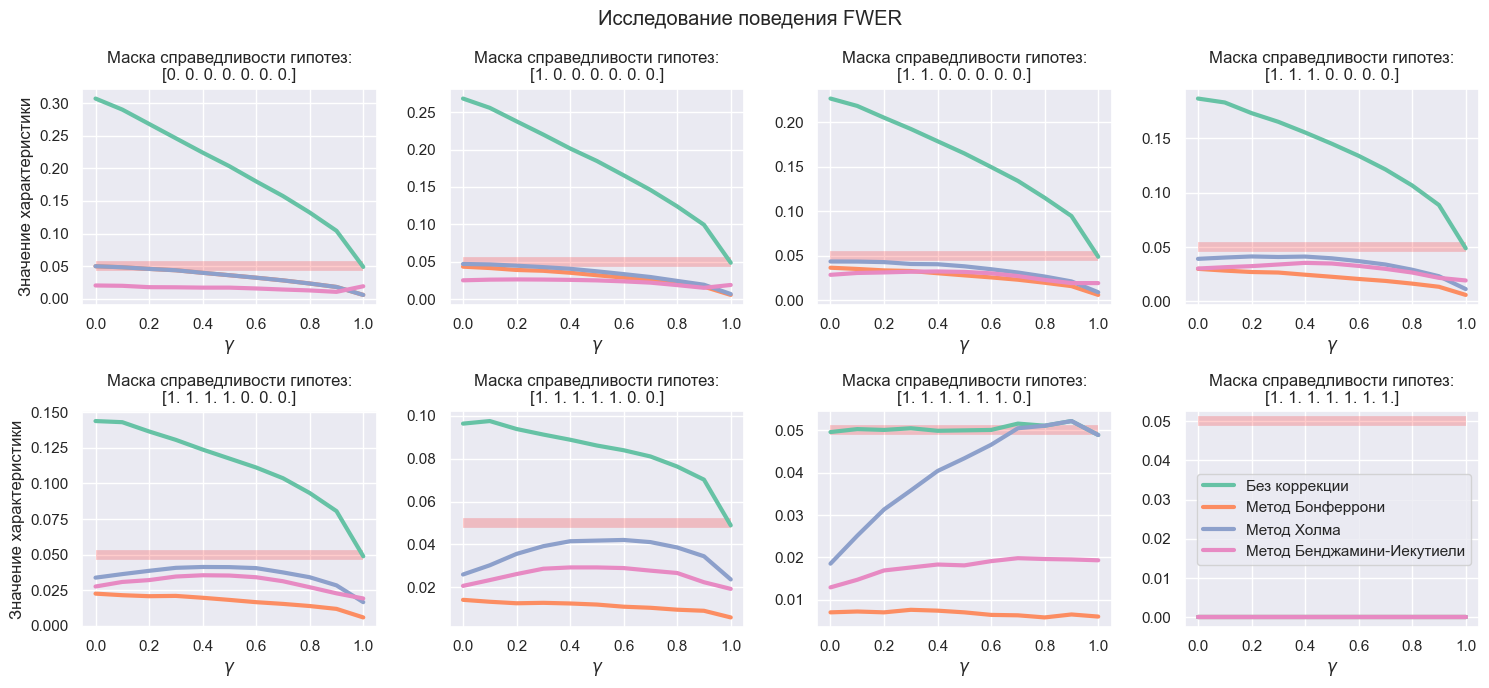

In [ ]:
plot_mht_metrics(
    "FWER", fwer, methods, methods_dict, hypothesis_mask_list_new, correlations_list
)

Рисуем график FDR.

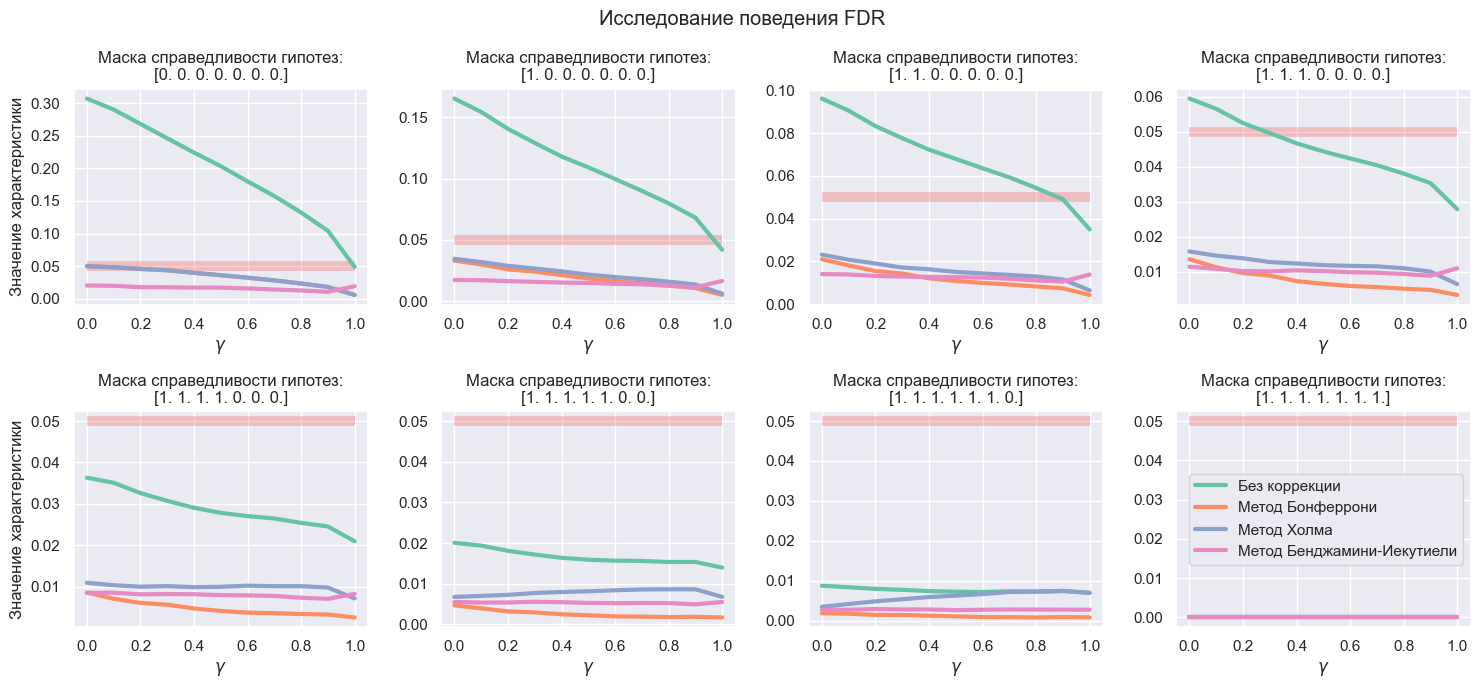

In [ ]:
plot_mht_metrics(
    "FDR", fdr, methods, methods_dict, hypothesis_mask_list_new, correlations_list
)

Рисуем график Power.

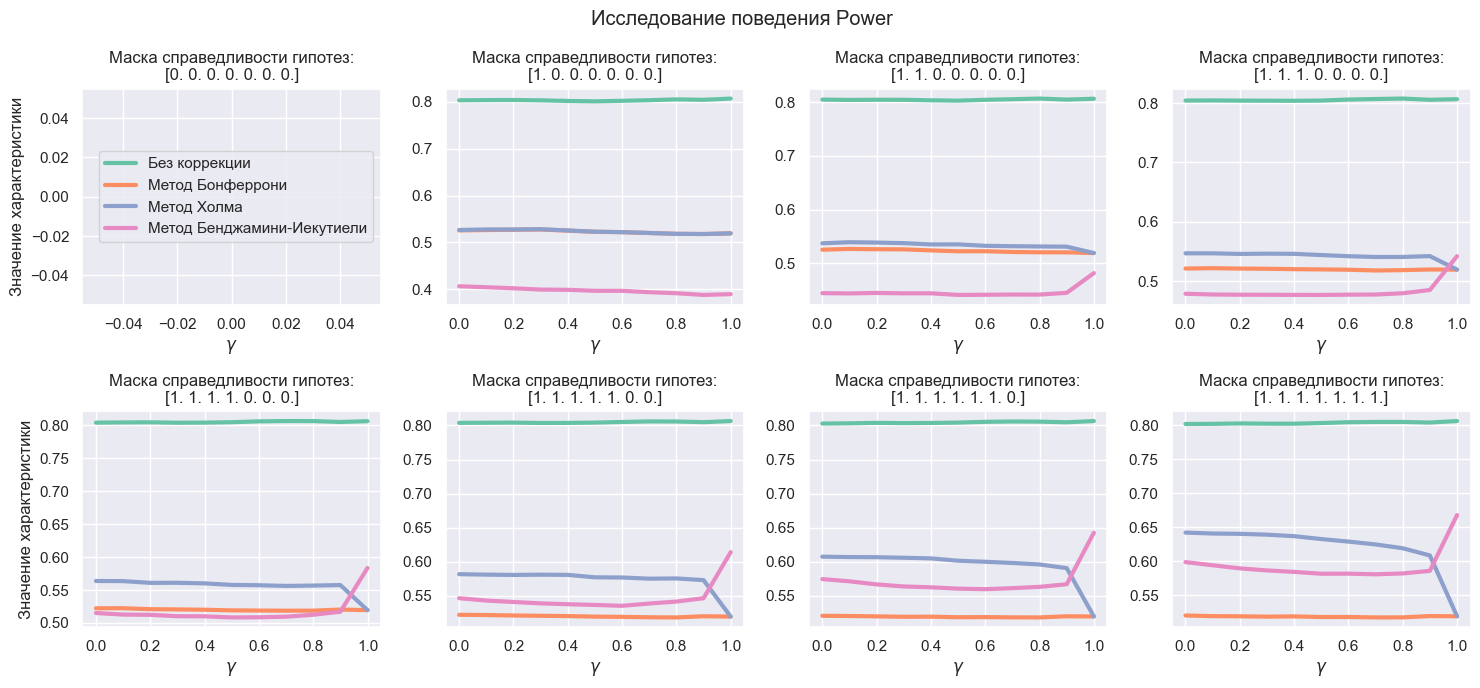

In [ ]:
plot_mht_metrics(
    "Power", power, methods, methods_dict, hypothesis_mask_list_new, correlations_list
)

**Выводы:**

- Особенности метода Холма относительно FDR, замеченные ранее, проявляются в случае, когда справедливы все гипотезы, кроме одной.
- С увеличением количества верных гипотез изменения FWER проявляются сильнее: более сильно возрастание и более сильно последующее убывание.
- Кроме того, с увеличением количества верных гипотез значение Power увеличивается для всех методов коррекции МПГ. Сильнее всего это проявляется на методе Бенджамини-Иекутиели. Кроме того, изменения становятся более заметными именно с увеличением количества верных гипотез.